In [26]:
import os, time, re
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nabstab.utils import load_model, train_model
from nabstab.constants import (
    AA2INDEX,
    CDR1_NUMBERS_STR,
    CDR2_NUMBERS_STR,
    CDR3_NUMBERS_STR,
)
from nabstab.datasets.classifier_dataset import pad_cdr2, NbStabilityDataset, pad_internal, pad_end

In [2]:
## Get the paths setup
if '__file__' in globals():
    current_dir = Path(__file__).resolve().parent
else:
    current_dir = Path.cwd()

data_dir = current_dir.parent / 'data'
checkpoints_dir = current_dir.parent / 'model_checkpoints'

In [3]:
lr_checkpoint = checkpoints_dir / 'LR/20231223_LR.pt'
lr_cdr12_checkpoint = checkpoints_dir / 'LR/cdr12.pt'
cnn_checkpoint = checkpoints_dir / 'CNN/cnn_24_fc_8.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#load models
lrmodel = load_model(
    checkpoint_path=lr_checkpoint,
    model_type='lr',
    device=device
)

lrmodel_cdr12 = load_model(
    checkpoint_path=lr_cdr12_checkpoint,
    model_type='lr',
    sequence_length = 20,
    device=device
)

cnnmodel = load_model(
    checkpoint_path=cnn_checkpoint,
    model_type='cnn',
    device=device
)


In [5]:
coefficients = lrmodel.classifier.linear.weight.detach().cpu().numpy().reshape(len(AA2INDEX), -1)

/var/folders/ny/4nnqnwz931lbj1c03ykgp8b80000gn/T/ipykernel_96190/673140108.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar


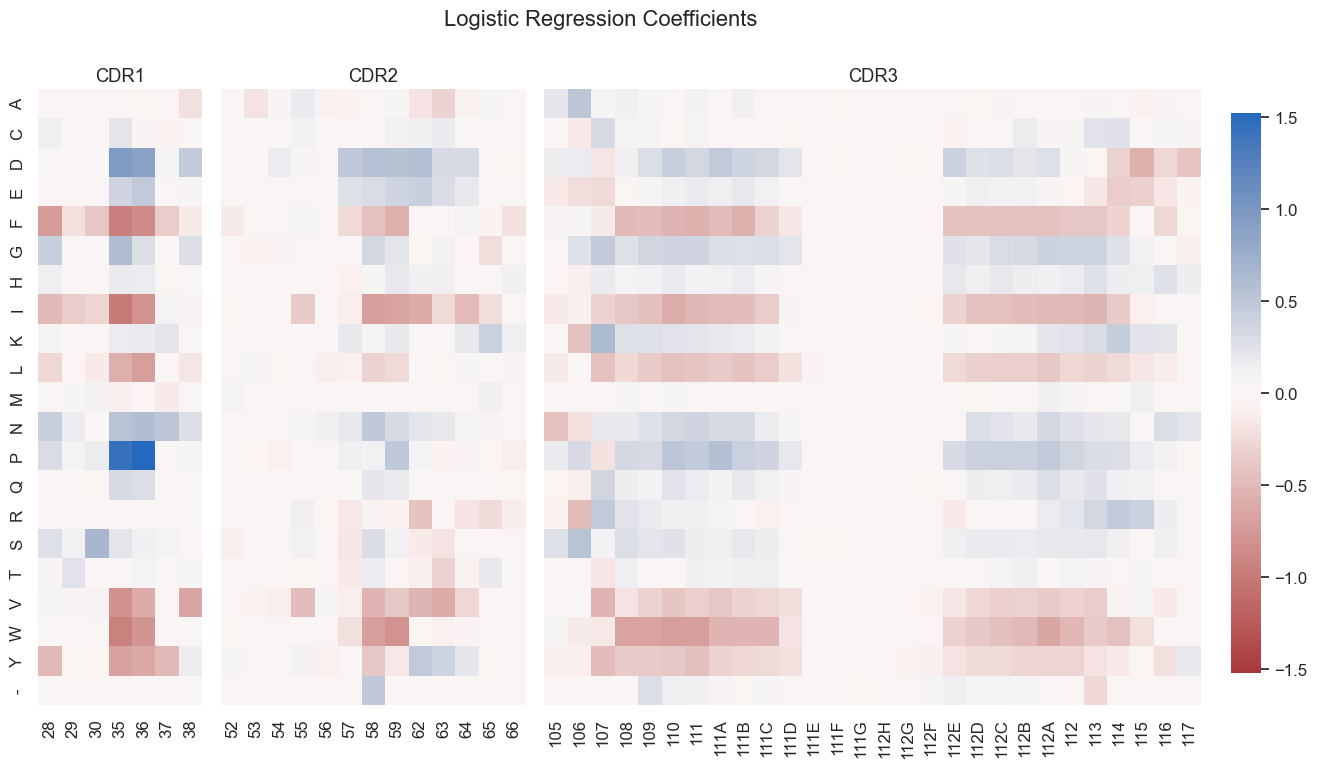

In [7]:
from matplotlib import gridspec

fig= plt.figure(figsize=(15, 8))

sns.set_theme(style = 'white', font_scale=1.1)

min_val = coefficients.min()
max_val = coefficients.max()

cdr1 = range(0,7)
cdr2 = range(7,20)
cdr3 = range(20,48)

def plot_region(ax, data_slice, title, xticklabels =[], yticklabels = [], **kwargs):
    g = sns.heatmap(data_slice, ax=ax, cbar=False, xticklabels=xticklabels, yticklabels=yticklabels, **kwargs)
    g.set_title(title)
    g.set_xlabel('')

# Create grid spec
gs = gridspec.GridSpec(1, 3, width_ratios=[len(cdr1), len(cdr2), len(cdr3)], wspace=0.05)

## other kwargs
plot_kwargs = {
    'vmin': -1 * max(abs(min_val), abs(max_val)),
    'vmax': max(abs(min_val), abs(max_val)),
    'cmap': 'vlag_r',
    'center': 0,
}

# Plot each region
ax1 = plt.subplot(gs[0])
plot_region(ax1, coefficients[:, cdr1], 'CDR1', xticklabels=CDR1_NUMBERS_STR, yticklabels=AA2INDEX.keys(), **plot_kwargs)

ax2 = plt.subplot(gs[1])
plot_region(ax2, coefficients[:, cdr2], 'CDR2', xticklabels=CDR2_NUMBERS_STR, **plot_kwargs)

ax3 = plt.subplot(gs[2])
plot_region(ax3, coefficients[:, cdr3], 'CDR3', xticklabels=CDR3_NUMBERS_STR, **plot_kwargs)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=90)

# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax1.collections[0], cax=cbar_ax)
cbar.outline.set_visible(False)

plt.suptitle('Logistic Regression Coefficients')
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar

plt.savefig(current_dir/ 'figure_4_outputs'/ 'logistic_regression_coefficients.pdf')

In [8]:
#save the coefficients as a csv
coefficients_df = pd.DataFrame(coefficients, index=AA2INDEX.keys(), columns = CDR1_NUMBERS_STR + CDR2_NUMBERS_STR + CDR3_NUMBERS_STR)
coefficients_df.to_csv(current_dir / 'figure_4_outputs' / 'logistic_regression_coefficients.csv')

## Rescale

Rescale the coeffiecients based on empirical frequencies

In [9]:
train_set = pd.read_csv(data_dir / 'model_training_data/ENN_train.csv')
ds = NbStabilityDataset(train_set, AA2INDEX, cdr3_max_len=28)

In [10]:
sums = torch.zeros((len(AA2INDEX), ds.sequence_length))
for i in range(0, len(ds), 64):
    seqs, labels = ds[i:i+64]
    oh = F.one_hot(seqs, len(AA2INDEX)).transpose(1,2)
    sums += oh.sum(dim=0)
#normalize by column
sums = sums / sums.sum(dim=0)
sums = sums.numpy()
sums_mask = sums < 0.01

In [11]:
sums_df = pd.DataFrame(sums, index=list(AA2INDEX.keys()), columns=CDR1_NUMBERS_STR + CDR2_NUMBERS_STR + CDR3_NUMBERS_STR)
sums_df.to_csv(current_dir / 'figure_4_outputs' / 'omnilib_per_site_aa_frequencies.csv')

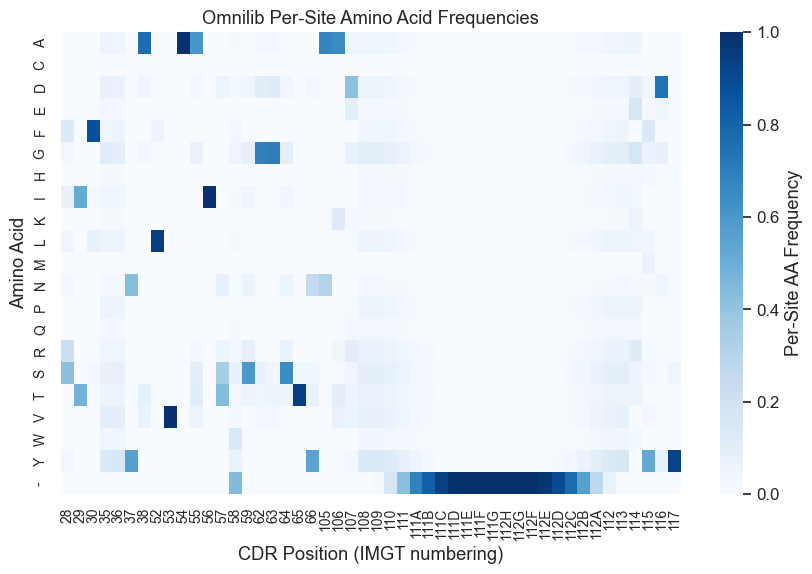

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(sums, cmap='Blues', ax=ax, cbar_kws={'label': 'Per-Site AA Frequency'}, annot=False,
            fmt='.2f', annot_kws={"size": 6, "rotation": 90})
ax.set_xticks(np.arange(sums.shape[1]) + 0.5, labels = CDR1_NUMBERS_STR + CDR2_NUMBERS_STR + CDR3_NUMBERS_STR, fontsize=10, rotation=90)
ax.set_yticks(np.arange(sums.shape[0]) + 0.5, labels=list(AA2INDEX.keys()), fontsize=10)
ax.set_title('Omnilib Per-Site Amino Acid Frequencies')
ax.set_xlabel('CDR Position (IMGT numbering)')
ax.set_ylabel('Amino Acid')

fig.savefig(current_dir / 'figure_4_outputs' / 'omnilib_per_site_aa_frequencies.pdf')

/var/folders/ny/4nnqnwz931lbj1c03ykgp8b80000gn/T/ipykernel_96190/487607029.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar


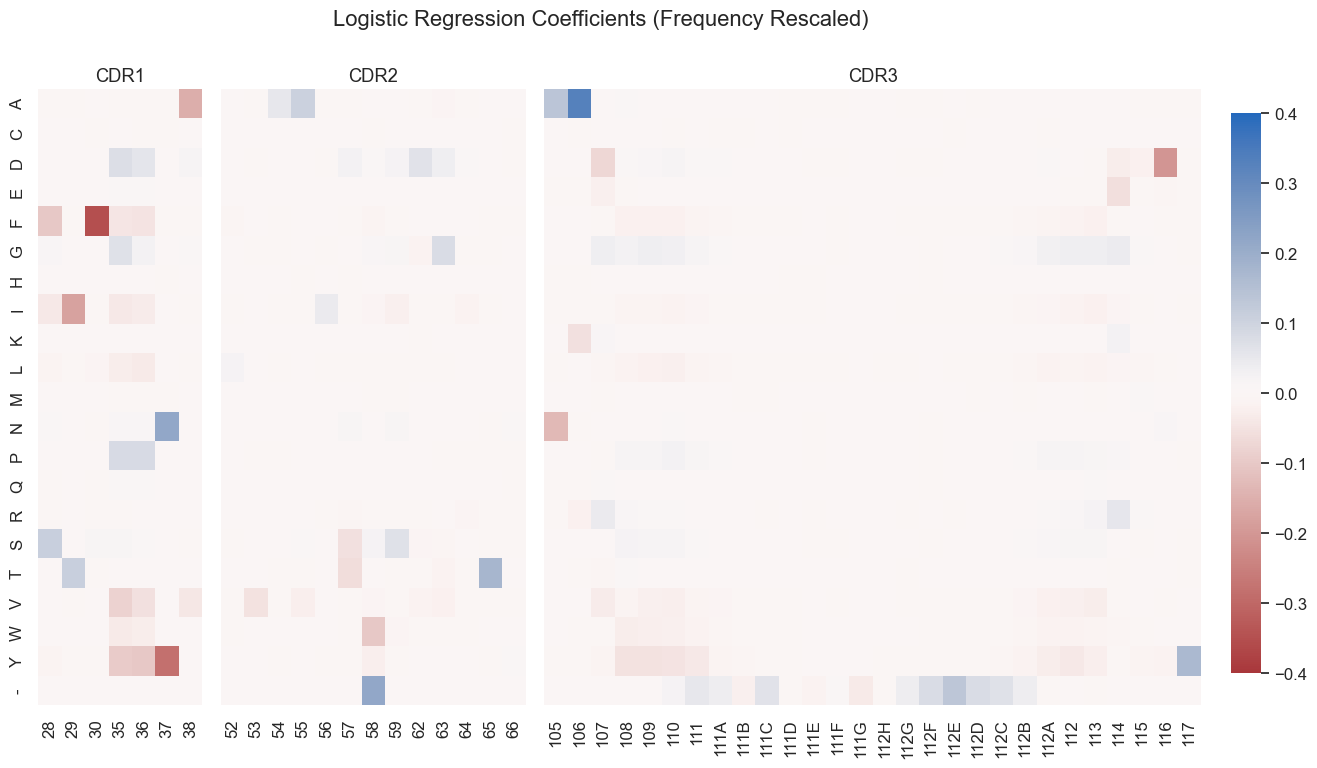

In [15]:
rescaled = coefficients * sums
fig= plt.figure(figsize=(15, 8))

sns.set_theme(style = 'white', font_scale=1.1)

min_val = -0.4
max_val = 0.4

cdr1 = range(0,7)
cdr2 = range(7,20)
cdr3 = range(20,48)

def plot_region(ax, data_slice, title, xticklabels =[], yticklabels = [], **kwargs):
    g = sns.heatmap(data_slice, ax=ax, cbar=False, xticklabels=xticklabels, yticklabels=yticklabels, **kwargs)
    g.set_title(title)
    g.set_xlabel('')

# Create grid spec
gs = gridspec.GridSpec(1, 3, width_ratios=[len(cdr1), len(cdr2), len(cdr3)], wspace=0.05)

## other kwargs
plot_kwargs = {
    'vmin': -1 * max(abs(min_val), abs(max_val)),
    'vmax': max(abs(min_val), abs(max_val)),
    'cmap': 'vlag_r',
    'center': 0,
}

# Plot each region
ax1 = plt.subplot(gs[0])
plot_region(ax1, rescaled[:, cdr1], 'CDR1', xticklabels=CDR1_NUMBERS_STR, yticklabels=AA2INDEX.keys(), **plot_kwargs)

ax2 = plt.subplot(gs[1])
plot_region(ax2, rescaled[:, cdr2], 'CDR2', xticklabels=CDR2_NUMBERS_STR, **plot_kwargs)

ax3 = plt.subplot(gs[2])
plot_region(ax3, rescaled[:, cdr3], 'CDR3', xticklabels=CDR3_NUMBERS_STR, **plot_kwargs)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='x', rotation=90)

# Create a common colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax1.collections[0], cax=cbar_ax)
cbar.outline.set_visible(False)

plt.suptitle('Logistic Regression Coefficients (Frequency Rescaled)')
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for suptitle and colorbar

plt.savefig(current_dir/ 'figure_4_outputs'/ 'logistic_regression_coefficients_rescaled.pdf')

In [16]:
coefficients_rescaled_df = pd.DataFrame(rescaled, index=AA2INDEX.keys(), columns = CDR1_NUMBERS_STR + CDR2_NUMBERS_STR + CDR3_NUMBERS_STR)
coefficients_rescaled_df.to_csv(current_dir / 'figure_4_outputs' / 'logistic_regression_coefficients_frequency_scaled.csv')

## Check a model with 35 and 36 pair potentials

This is an enhanced logistic regression that uses individual site coefficients, and a pair coefficient for positions 35 and 36 in CDR1 to see how they interact.

In [20]:
class CDR1EpistasisDataset(Dataset):
    def __init__(self, df, alphabet, pad_internally=True, cdr3_max = 28):

        if isinstance(df, str):
            df = pd.read_csv(df)
            
        cdr3_target = max((df.CDR3.str.len().max(), cdr3_max))
        print(f'CDR3 target length: {cdr3_target}')

        if pad_internally:
            df['cdr2_padded'] = df.CDR2.apply(pad_cdr2)
            df['cdr3_padded'] = df.CDR3.apply(lambda x: pad_internal(x, cdr3_target))
            df['padded_sequence'] = df.CDR1 + df.cdr2_padded + df.cdr3_padded
        else:
            full_seq = df.CDR1 + df.CDR2 + df.CDR3
            max_len = full_seq.str.len().max()
            df['padded_sequence'] = full_seq.apply(lambda x: pad_end(x, target_len=max_len))

        self.sequence_length = len(df.padded_sequence.iloc[0])

        self.sequences = df.padded_sequence.values
        self.numseqs = torch.vstack([torch.tensor([alphabet.get(aa, 20) for aa in seq], dtype=torch.long) for seq in self.sequences])
        self.labels = torch.tensor((df.stability == 'high').values).float()
        pair_cdr1 = torch.zeros(self.numseqs.shape[0], len(alphabet), len(alphabet))
        pair_cdr1[torch.arange(self.numseqs.shape[0]), self.numseqs[:, 3], self.numseqs[:, 4]] = 1
        self.pair_cdr1 = pair_cdr1

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.numseqs[idx], self.pair_cdr1[idx], self.labels[idx]


In [21]:
df = pd.read_csv(data_dir / 'model_training_data/ENN_train.csv')
ds = CDR1EpistasisDataset(df, AA2INDEX, pad_internally=True, cdr3_max=28)
train_ds, val_ds = torch.utils.data.random_split(ds, [0.8, 0.2])
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

CDR3 target length: 28


### Define the enhanced LR Model

In [33]:
class SimpleLR(nn.Module):
    def __init__(self, alphabet, sequence_length, num_combinations):
        super(SimpleLR, self).__init__()
        self.alphabet = alphabet
        self.sequence_length = sequence_length
        self.num_combinations = num_combinations

        input_size = len(alphabet) * sequence_length + len(alphabet) **2
        self.linear = nn.Linear(input_size, 1)

        self.criteria = nn.BCEWithLogitsLoss()
    
    def forward(self, x, pair):
        one_hot = F.one_hot(x, num_classes=len(self.alphabet)).transpose(1,2).float()
        one_hot = one_hot.reshape(-1, self.sequence_length * len(self.alphabet))
        pair = pair.reshape(-1, len(self.alphabet) * len(self.alphabet))

        x = torch.cat([one_hot, pair], dim=1)
        return self.linear(x)
    
    def train_step(self, batch):
        x, pair1, y = batch
        y_hat = self.forward(x, pair1)
        loss = self.criteria(y_hat, y.unsqueeze(1))
        acc = ((y_hat > 0) == y.unsqueeze(1)).float().mean()
        return loss, acc
    
    def val_step(self, batch):
        x, pair, y = batch
        y_hat = self.forward(x, pair)
        loss = self.criteria(y_hat, y.unsqueeze(1))
        acc = ((y_hat > 0) == y.unsqueeze(1)).float().mean()
        return loss, acc
    
    def configure_optimizers(self, lr=0.001, weight_decay=0.0):
        return optim.Adam(self.parameters(), lr=0.001, weight_decay=weight_decay)

In [34]:
model = SimpleLR(
    AA2INDEX,
    sequence_length=ds.sequence_length,
    num_combinations=1
)
optimizer = model.configure_optimizers(lr = 1e-3, weight_decay=1e-4)

Slightly modified training code since there are two items in the input

In [35]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    losses = []
    accuracies = []
    pbar = tqdm(train_loader)
    for i,batch in enumerate(pbar):
        optimizer.zero_grad()
        batch = [b.to(device) for b in batch]
        loss, acc = model.train_step(batch)
        losses.append(loss.item())
        accuracies.append(acc.item())
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            pbar.set_description(f'Loss: {np.mean(losses):.4f}, Acc: {np.mean(accuracies):.4f}')
    return np.mean(losses), np.mean(accuracies)

def val_epoch(model, val_loader, device):
    model.eval()
    losses = []
    accuracies = []
    pbar = tqdm(val_loader)
    with torch.no_grad():
        for i,batch in enumerate(pbar):
            batch = [b.to(device) for b in batch]
            loss, acc = model.val_step(batch)
            losses.append(loss.item())
            accuracies.append(acc.item())
            if i % 100 == 0:
                pbar.set_description(f'Loss: {np.mean(losses):.4f}, Acc: {np.mean(accuracies):.4f}')
    return np.mean(losses), np.mean(accuracies)

In [36]:
epochs = 3

for epoch in np.arange(epochs):
    train_loss, train_acc = train_epoch(model, train_dl, optimizer, device)
    val_loss, val_acc = val_epoch(model, val_dl, device)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Loss: 0.4238, Acc: 0.8209: 100%|██████████| 3677/3677 [00:01<00:00, 1839.65it/s]


Epoch 0, Train Loss: 0.4345, Train Acc: 0.8170, Val Loss: 0.4240, Val Acc: 0.8207


Loss: 0.4237, Acc: 0.8210: 100%|██████████| 3677/3677 [00:01<00:00, 1925.50it/s]


Epoch 1, Train Loss: 0.4241, Train Acc: 0.8206, Val Loss: 0.4239, Val Acc: 0.8209


Loss: 0.4246, Acc: 0.8203: 100%|██████████| 3677/3677 [00:01<00:00, 1889.68it/s]

Epoch 2, Train Loss: 0.4241, Train Acc: 0.8208, Val Loss: 0.4248, Val Acc: 0.8202


In [44]:
weights = model.linear.weight.detach().cpu().numpy()
chunk1 = len(AA2INDEX) * ds.sequence_length
chunk2 = len(AA2INDEX) ** 2

reg_weights = weights[0, :chunk1].reshape(len(AA2INDEX), ds.sequence_length)
pair_weights = weights[0, chunk1:chunk1 + chunk2].reshape(len(AA2INDEX), len(AA2INDEX))

Rescale by frequencies

In [46]:
reg_freq = np.zeros((len(AA2INDEX), ds.sequence_length))
pair_freq = np.zeros((len(AA2INDEX), len(AA2INDEX)))

for batch in train_dl:
    boh = F.one_hot(batch[0], num_classes=len(AA2INDEX)).transpose(1,2).float()
    reg_freq += boh.sum(dim=0).numpy()
    pair_freq += batch[1].sum(dim=0).numpy()

reg_freq_weights = reg_freq / reg_freq.sum(axis=0)
pair_freq_weights = pair_freq / pair_freq.sum(axis=0)

#replace NAN with 0
reg_freq_weights = np.nan_to_num(reg_freq_weights)
pair_freq_weights = np.nan_to_num(pair_freq_weights)

rescaled_reg = reg_weights * reg_freq_weights
rescaled_pair = pair_weights * pair_freq_weights

/var/folders/ny/4nnqnwz931lbj1c03ykgp8b80000gn/T/ipykernel_96190/4204691101.py:10: RuntimeWarning: invalid value encountered in divide
  pair_freq_weights = pair_freq / pair_freq.sum(axis=0)


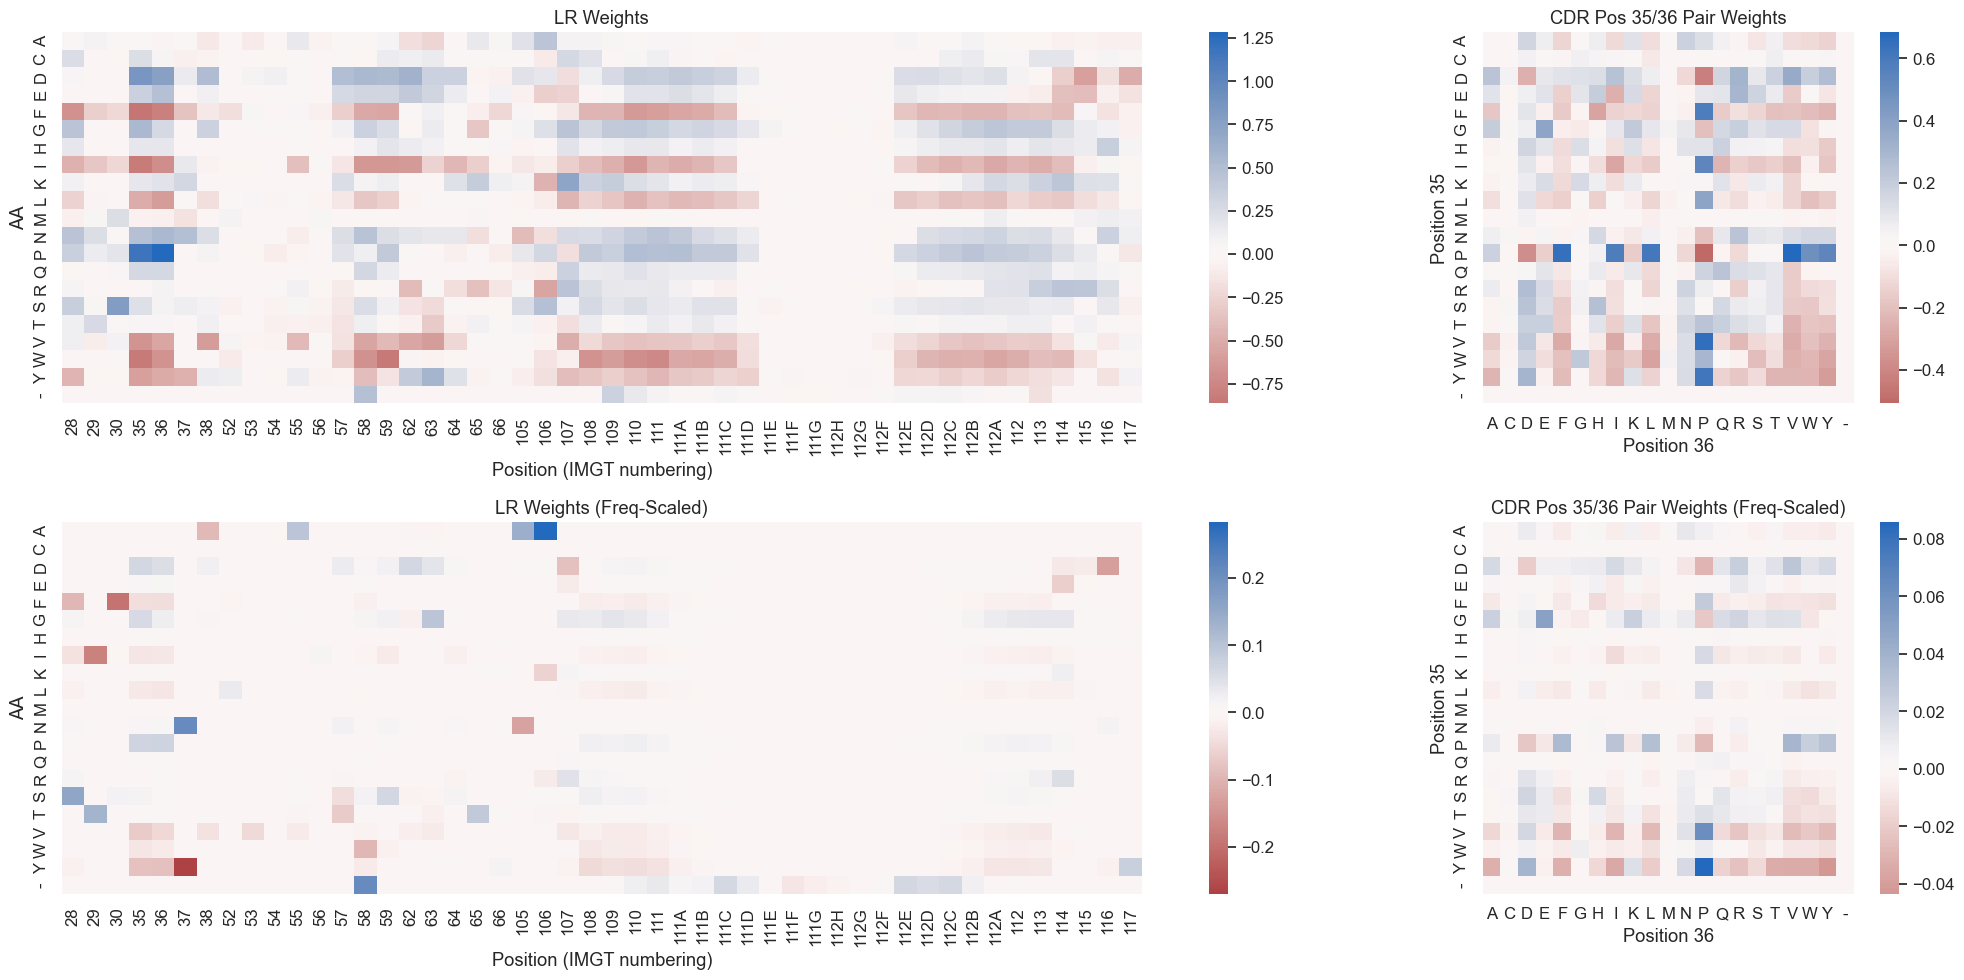

In [50]:
mosaic = '''AAAAABB
CCCCCDD'''  
fig, axs_mosaic = plt.subplot_mosaic(mosaic, figsize=(20, 10))
axs_mosaic['A'].set_title('LR Weights')
axs_mosaic['B'].set_title('CDR Pos 35/36 Pair Weights')

sns.heatmap(reg_weights, ax=axs_mosaic['A'], cmap='vlag_r', center=0, yticklabels=list(AA2INDEX.keys()), xticklabels=CDR1_NUMBERS_STR + CDR2_NUMBERS_STR + CDR3_NUMBERS_STR)
sns.heatmap(pair_weights, ax=axs_mosaic['B'], cmap='vlag_r', center=0, xticklabels=list(AA2INDEX.keys()), yticklabels=list(AA2INDEX.keys()), square=True)

axs_mosaic['C'].set_title('LR Weights (Freq-Scaled)')
axs_mosaic['D'].set_title('CDR Pos 35/36 Pair Weights (Freq-Scaled)')
sns.heatmap(rescaled_reg, ax=axs_mosaic['C'], cmap='vlag_r', center=0, yticklabels=list(AA2INDEX.keys()), xticklabels=CDR1_NUMBERS_STR + CDR2_NUMBERS_STR + CDR3_NUMBERS_STR)
sns.heatmap(rescaled_pair, ax=axs_mosaic['D'], cmap='vlag_r', center=0, xticklabels=list(AA2INDEX.keys()), yticklabels=list(AA2INDEX.keys()), square=True)

axs_mosaic['A'].set_ylabel('AA')
axs_mosaic['A'].set_xlabel('Position (IMGT numbering)')
axs_mosaic['B'].set_ylabel('Position 35')
axs_mosaic['B'].set_xlabel('Position 36')
axs_mosaic['C'].set_ylabel('AA')
axs_mosaic['C'].set_xlabel('Position (IMGT numbering)')
axs_mosaic['D'].set_ylabel('Position 35')
axs_mosaic['D'].set_xlabel('Position 36')

fig.tight_layout()
plt.savefig(current_dir / 'figure_4_outputs' / 'lr_weights_epistasis.pdf')